In [1]:

from idr import connection
import os
import numpy as np
import matplotlib.pyplot as plt
from pandas import Series,DataFrame,read_csv, merge,concat,read_hdf
import omero

import skimage.measure as skmes
import skimage.transform as sktrans


In [2]:
def getBulkAnnotationAsDf(screenID,conn):
#    Download the annotation frile from a screen as a Pandas DataFrame
    sc=conn.getObject('Screen',screenID)
    for ann in sc.listAnnotations():
        if isinstance(ann, omero.gateway.FileAnnotationWrapper):
            if (ann.getFile().getName()=='bulk_annotations'):
                if (ann.getFile().getSize()> 147625090): #about 140Mb?
                    print "that's a big file..."
                    return None
                ofId=ann.getFile().getId()
                break


    original_file = omero.model.OriginalFileI(ofId, False)

    openTable = conn.c.sf.sharedResources().openTable(original_file)
    rowCount = openTable.getNumberOfRows()

    #table to df

    column_names = [col.name for col in openTable.getHeaders()]

    black_list = []
    column_indices = []
    for column_name in column_names:
        if column_name in black_list:
            continue
        column_indices.append(column_names.index(column_name))

    table_data = openTable.slice(column_indices, None)
    data = []
    for index in range(rowCount):
        row_values = [column.values[index] for column in table_data.columns]
        data.append(row_values)

    dfAnn=DataFrame(data)
    dfAnn.columns=column_names
    return dfAnn

In [3]:
def getLengthsFromStrain(astrain,lenlen=100):
    lengths=[]
    for we in sysgroba[sysgroba["Characteristics [Strain]"]==astrain].Well.values:
        we=conn.getObject('Well',we)
        ii=0
        while True:
            imid=we.getImage(ii)
            ii=ii+1
            if imid == None:
                break
            imId=imid.getId()
            result = roiService.findByImage(imId, None)
            for ii in range(len(result.rois)):

                #get the coordinates of the outline of the ROI
                s=result.rois[ii].copyShapes()[0]
                pts=s.getPoints().getValue()
                pts=[int(xx) for x in pts.split(' ') for xx in x.split(',') ]
                pts=np.reshape(pts,(len(pts)/2,2))

                #from coordinates to mask image
                M0,m0,M1,m1=pts[:,0].max(),pts[:,0].min(),pts[:,1].max(),pts[:,1].min()
                imroi=np.zeros((M0-m0+1,M1-m1+1))
                for i in range(pts.shape[0]):
                    imroi[pts[i,0]-m0,pts[i,1]-m1]=1    

                iml=skmes.label(1-imroi,connectivity=1)
                imroi=1*(iml==iml[iml.shape[0]/2,iml.shape[1]/2])

                #length of cell as length of bounding box of rotated image (thanks to the particular shape of yeast cells)
                ori=skmes.regionprops(1*imroi)[0].orientation
                imroi=sktrans.rotate(1.*imroi,-ori/(np.pi)*180,resize=True, order=0)
                bbox=skmes.regionprops(skmes.label(imroi))[0].bbox
                lengths.append(bbox[3]-bbox[1])
        if len(lengths)>lenlen: #to speed things up when there are a lot of images...
            break
    return lengths

In [4]:
conn = connection()
roiService = conn.getRoiService()


In [5]:
#get annotation of a screen

scId=3 #sysgro
sysgroba=getBulkAnnotationAsDf(scId,conn)



In [6]:
#extract length of cells as stored in ROIs in the IDR

WTls=getLengthsFromStrain('MS1404',lenlen=200)
ash2ls=getLengthsFromStrain('ash2',lenlen=200)

pixsize=.11  #could be taken from IDR metadata
ash2ls=[x*pixsize for x in ash2ls]
WTls=[x*pixsize for x in WTls]

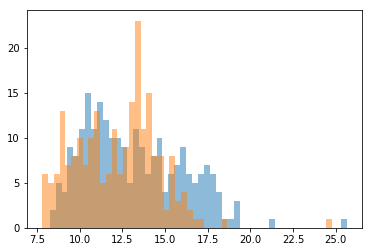

In [7]:
plt.figure()
h1=plt.hist(ash2ls,bins=50, alpha=.5)
h2=plt.hist(WTls,bins=50, alpha=.5)
    

In [8]:
from scipy.stats import ttest_ind

ttest_ind(WTls,ash2ls)

Ttest_indResult(statistic=-3.9099766965779321, pvalue=0.00010626848336313707)

# not used